In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os

import bin2cell as b2c

#create directory for stardist input/output files
os.makedirs("stardist", exist_ok=True)

In [2]:
os.chdir('/nfs/team205/kk18/notebooks/Foetal/VisiumHD/re-seq_mpp0p3')
os.getcwd()

'/nfs/team205/kk18/notebooks/Foetal/VisiumHD/re-seq_mpp0p3'

# Read in data

In [7]:
!ls /lustre/scratch126/cellgen/team205/sharedData/ny1/24-11-26-visiumhd/HEA_FOET14880396/outs

binned_outputs	  metrics_summary.csv  probe_set.csv  web_summary.html
feature_slice.h5  molecule_info.h5     spatial


In [3]:
path = "/lustre/scratch126/cellgen/team205/sharedData/ny1/24-11-26-visiumhd/HEA_FOET14880396/outs/binned_outputs/square_002um"
spaceranger_image_path = '/lustre/scratch126/cellgen/team205/sharedData/ny1/24-11-26-visiumhd/HEA_FOET14880396/outs/spatial'
source_image_path = "/lustre/scratch126/cellgen/team205/kk18/VisiumHD/source_images/C194_HEA_0_FFPE_1_STAN_1EAF2_s3_2024_04_23_13_40_00.tiff"

In [4]:
adata = b2c.read_visium(path, 
                        spaceranger_image_path=spaceranger_image_path, 
                        source_image_path = source_image_path
                       )
adata.var_names_make_unique()
adata

anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5032713 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

# Pre-processing

Let's slightly filter the object - require the genes to show up in three spots, and require the spots to have any information at all (the data is extremely sparse at this stage).

In [5]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 5001851 × 18051
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
mpp = 0.3
b2c.scaled_he_image(adata, mpp=mpp, save_path="stardist/he.tiff")

Cropped spatial coordinates key: spatial_cropped_150_buffer
Image key: 0.3_mpp_150_buffer


Visium HD suffers from variable bin sizing. When printing the chips, the 2um bins can have about 10% variability in their width/height. Inspecting the total counts per spot reveals a characteristic striped appearance, with some rows/columns capturing visibly fewer transcripts than others.

To overcome this, b2c.destripe() identifies a user-specified quantile (by default 0.99) of total counts for each row, then divides the counts of the spots in that row by that value. This procedure is then repeated for the columns. .obs[adjusted_counts_key] (by default "n_counts_adjusted") is obtained by multiplying the resulting per-spot factor by the global quantile of count totals, and the count matrix is by default rescaled to match it.

In [8]:
b2c.destripe(adata,
             quantile=0.99, 
    counts_key='n_counts',
    factor_key='destripe_factor',
    adjusted_counts_key='n_counts_adjusted',
    adjust_counts=True)

_construct.py (149): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Prior to the adjustment, the count total has a visible striped appearance. The effect is diminished after the correction.

anndata.py (1146): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1146): Trying to modify attribute `.var` of view, initializing view as actual.


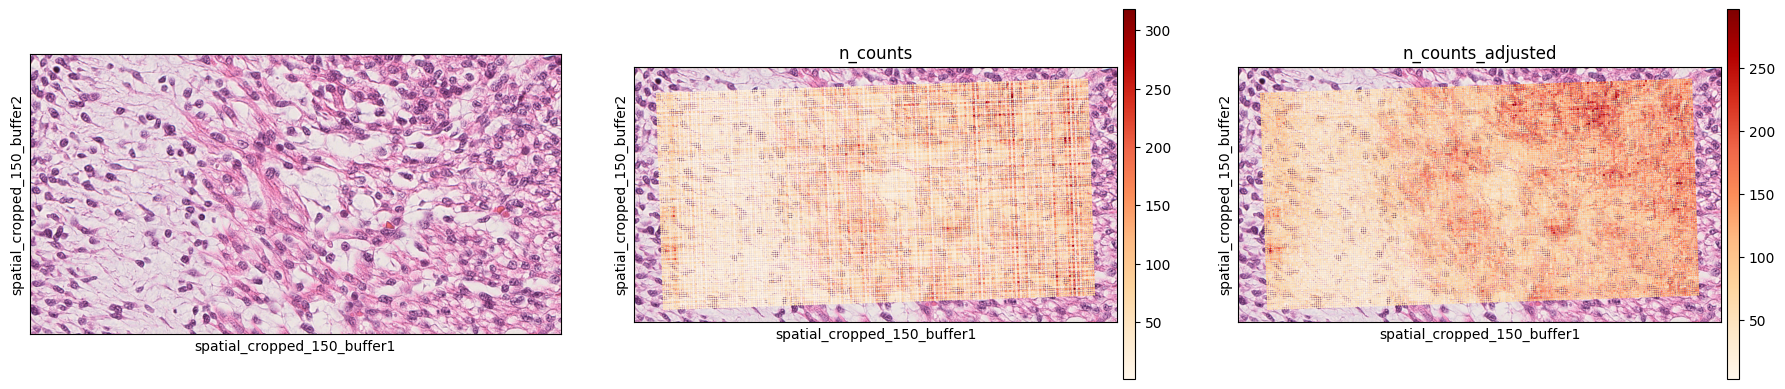

In [9]:
#define a mask to easily pull out this region of the object in the future
mask = ((adata.obs['array_row'] >= 1450) & 
        (adata.obs['array_row'] <= 1550) & 
        (adata.obs['array_col'] >= 1400) & 
        (adata.obs['array_col'] <= 1600)
       )

bdata = adata[mask]
sc.pl.spatial(bdata, color=[None, "n_counts", "n_counts_adjusted"], color_map="OrRd",
              img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")

In [10]:
adata.shape

(5001851, 18051)

# Plot HE cell segmentation

We can now load the resulting cell calls into the object. For any given bin, its corresponding pixel in the segmented image will be located and any potential label transferred over. It's important to inform b2c.insert_labels() of whether the segmented image was based on array (GEX visualisation of the grid) or spatial (rescaled H&E image) coordinates, which exact spatial representation matches the image, and what mpp was used.

In [11]:
prob_thresh_dict = {
    '0p01':0.01,
     '0p03':0.03,
    '0p05':0.05,
    '0p1':0.1,
    'default':'default'
}

for key,prob_thresh in prob_thresh_dict.items():
    print(f'### {key} ###')
    b2c.insert_labels(adata, 
                  labels_npz_path=f"stardist/he_{key}.npz", 
                  basis="spatial",
                  spatial_key="spatial_cropped_150_buffer",
                  mpp=mpp, 
                  labels_key=f"labels_he_{key}"
                 )

adata

### 0p01 ###
### 0p03 ###
### 0p05 ###
### 0p1 ###
### default ###


AnnData object with n_obs × n_vars = 5001851 × 18051
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he_0p01', 'labels_he_0p03', 'labels_he_0p05', 'labels_he_0p1', 'labels_he_default'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'bin2cell'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

Let's visualise the nuclear H&E segmentation on our selected region. The nuclei are identified successfully.

2683271253.py (12): Trying to modify attribute `.obs` of view, initializing view as actual.


96


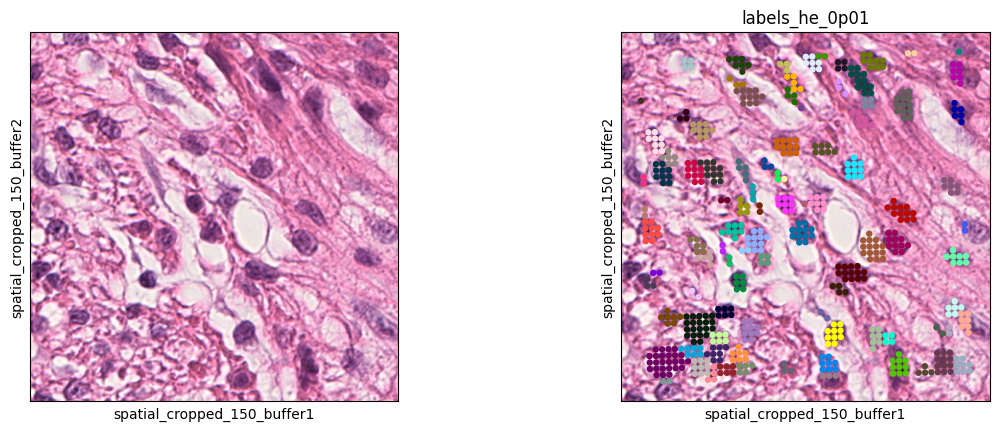

2683271253.py (12): Trying to modify attribute `.obs` of view, initializing view as actual.


71


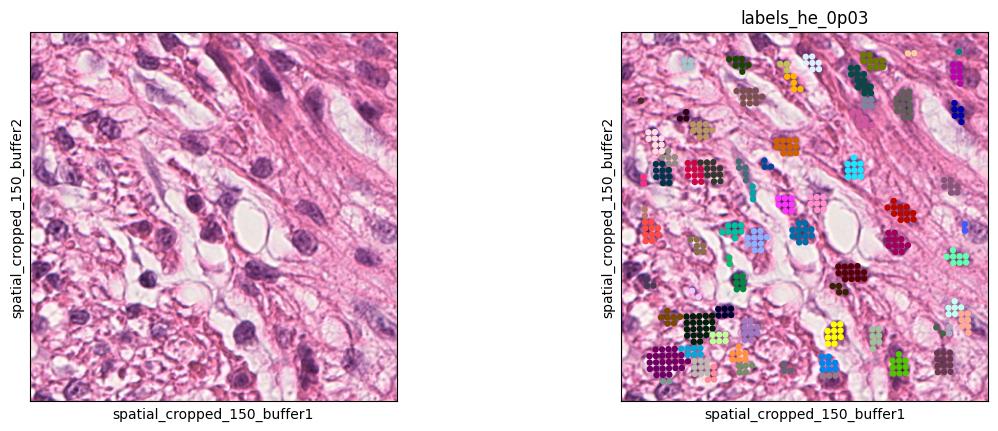

2683271253.py (12): Trying to modify attribute `.obs` of view, initializing view as actual.


62


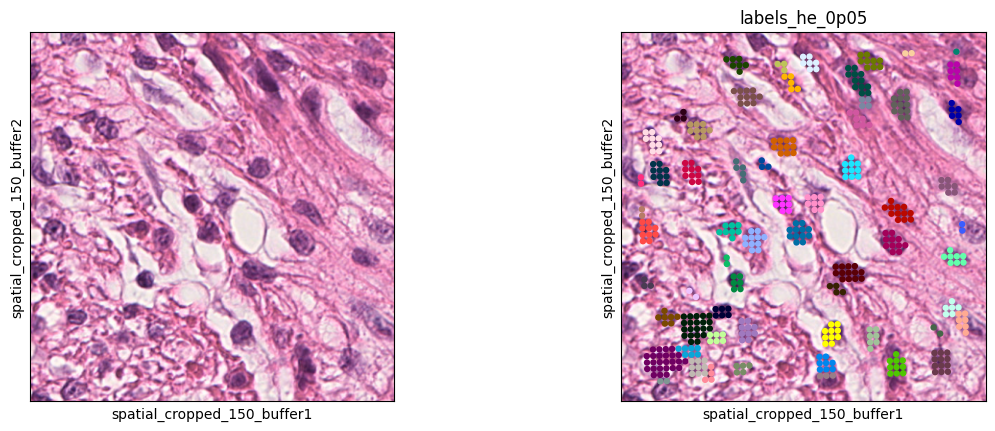

2683271253.py (12): Trying to modify attribute `.obs` of view, initializing view as actual.


56


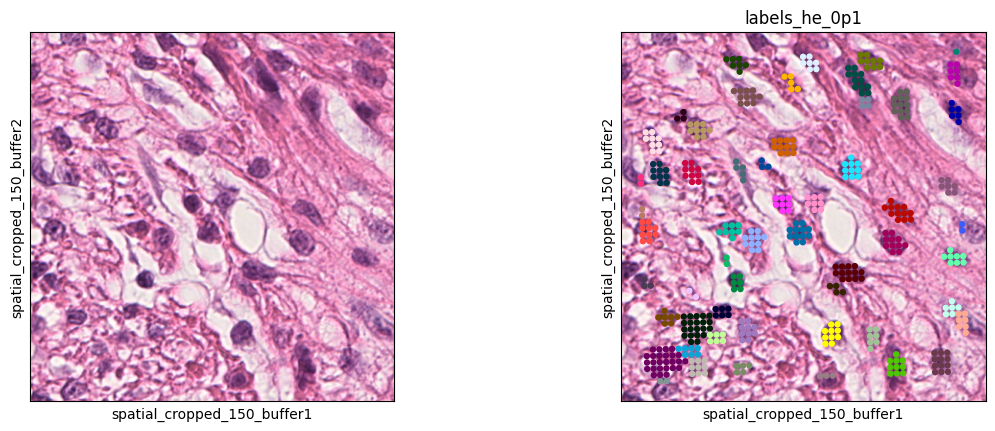

2683271253.py (12): Trying to modify attribute `.obs` of view, initializing view as actual.


32


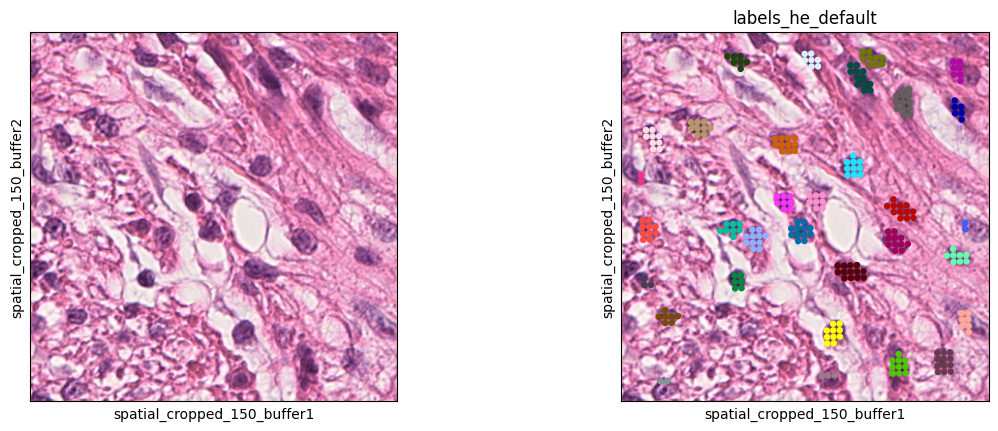

In [12]:
mask = ((adata.obs['array_row'] >= 1050) & 
        (adata.obs['array_row'] <= 1100) & 
        (adata.obs['array_col'] >= 1100) & 
        (adata.obs['array_col'] <= 1150)
       )

bdata = adata[mask]

for key in prob_thresh_dict.keys():
    #0 means unassigned
    bdata = bdata[bdata.obs[f'labels_he_{key}']>0]
    bdata.obs[f'labels_he_{key}'] = bdata.obs[f'labels_he_{key}'].astype(str)
    print(len(set(bdata.obs[f'labels_he_{key}'])))
    sc.pl.spatial(bdata, color=[None,f'labels_he_{key}'], 
                  img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer", legend_loc=None,
                  ncols=2
                 )

# Select prob_thresh

In [14]:
prob_thresh_sel = '0p05' 
adata.obs['labels_he_sel'] = adata.obs[f'labels_he_{prob_thresh_sel}']

The package comes with a utility function to visualise StarDist segmentation on a fragment of the input image. As we can see, the calls are faithfully captured in the bins.

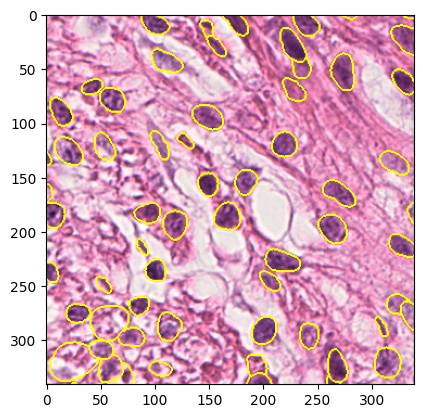

In [16]:
#the label viewer wants a crop of the processed image
#get the corresponding coordinates spanning the subset object
crop = b2c.get_crop(bdata, basis="spatial", spatial_key="spatial_cropped_150_buffer", mpp=mpp)

rendered = b2c.view_labels(image_path="stardist/he.tiff", 
                           labels_npz_path=f"stardist/he_{prob_thresh_sel}.npz", 
                           crop=crop
                          )
plt.imshow(rendered)

# Expand labels

However, StarDist's H&E segmentation merely identifies nuclei, while there's more to a cell than just the nucleus. b2c.expand_labels() finds bins up to max_bin_distance (by default 2) bins away from a labelled nucleus, and joins them into the corresponding cell. In the event of a bin being equidistant from two nuclei, it's assigned to one based on the similarity of their gene expression profiles, as represented in PCA space.

In [17]:
%%time
max_bin_distance_list = [1,2,3,4]
for max_bin_distance in max_bin_distance_list:
    print(max_bin_distance)
    b2c.expand_labels(adata, 
                      labels_key=f"labels_he_sel", 
                      expanded_labels_key=f"labels_he_expanded_{max_bin_distance}",
                      max_bin_distance=max_bin_distance
                     )

1
2
3
4
CPU times: user 5min 23s, sys: 14.2 s, total: 5min 37s
Wall time: 7min 18s


788255881.py (6): Trying to modify attribute `.obs` of view, initializing view as actual.


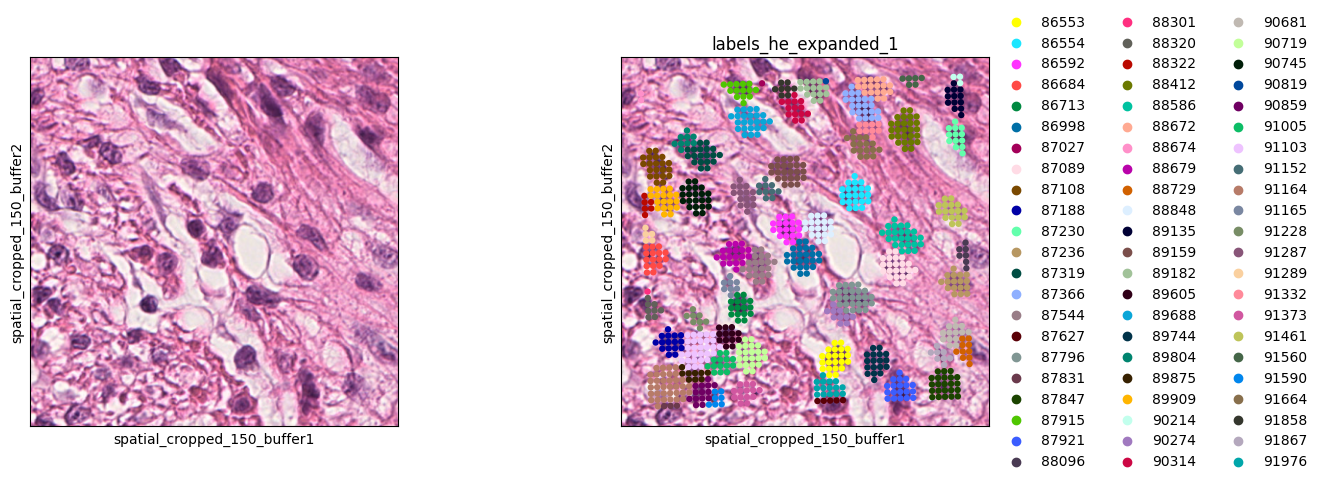

788255881.py (6): Trying to modify attribute `.obs` of view, initializing view as actual.


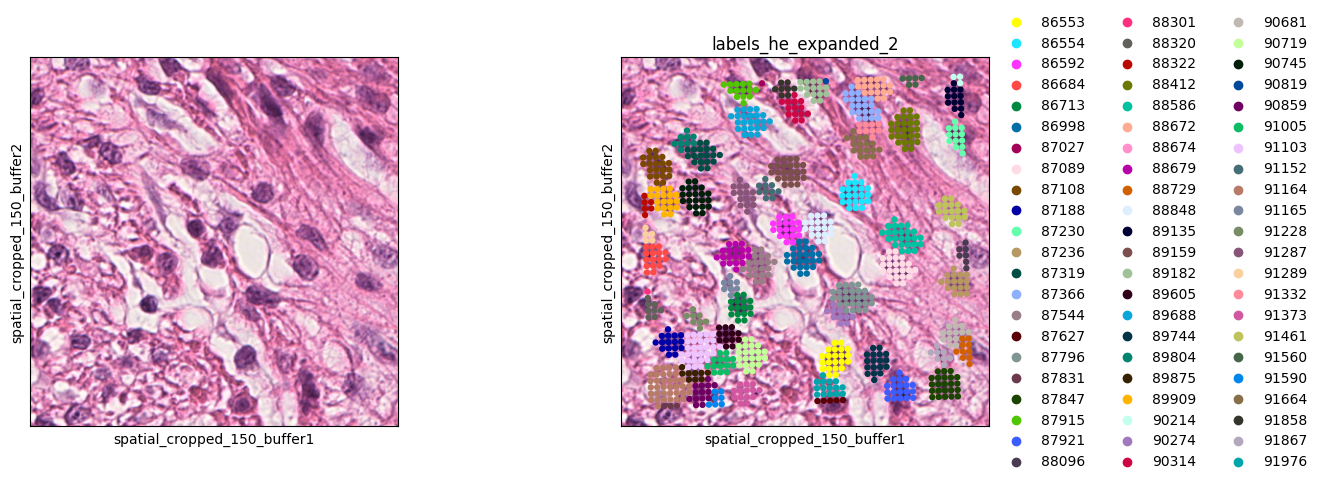

788255881.py (6): Trying to modify attribute `.obs` of view, initializing view as actual.


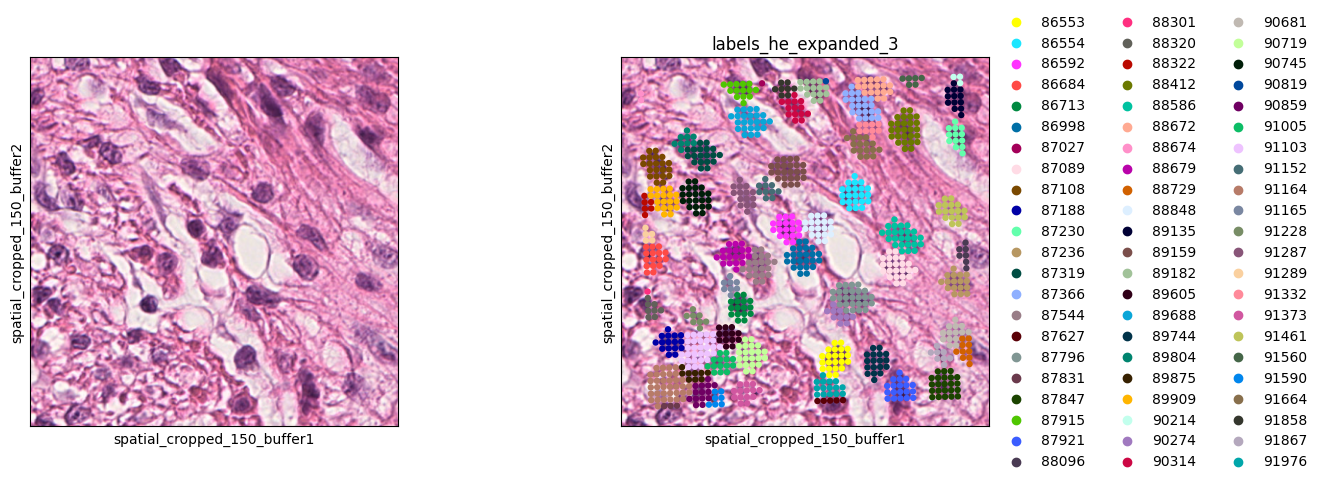

788255881.py (6): Trying to modify attribute `.obs` of view, initializing view as actual.


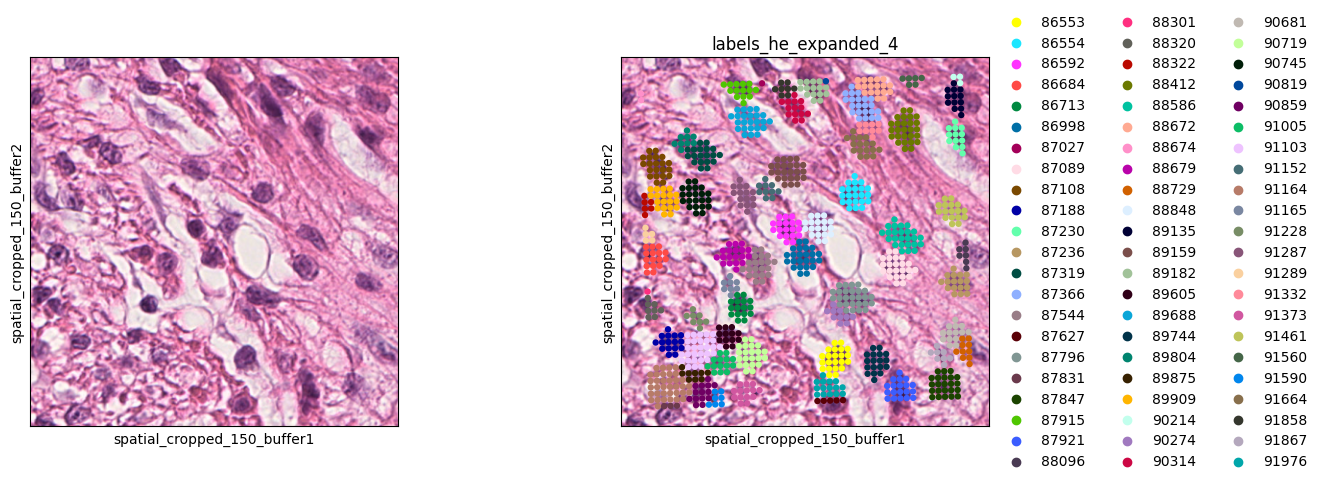

In [18]:
bdata = adata[mask]

for max_bin_distance in max_bin_distance_list:
    #0 means unassigned
    bdata = bdata[bdata.obs[f"labels_he_expanded_{max_bin_distance}"]>0]
    bdata.obs[f"labels_he_expanded_{max_bin_distance}"] = bdata.obs[f"labels_he_expanded_{max_bin_distance}"].astype(str)

    sc.pl.spatial(bdata, color=[None, f"labels_he_expanded_{max_bin_distance}"], 
                  img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")

it doesn't change --> go with 2

In [19]:
max_bin_distance_sel = 2
adata.obs['labels_he_expanded_sel'] = adata.obs[f"labels_he_expanded_{max_bin_distance_sel}"]

# Save the object

In [ ]:
adata.write('/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/HEA_FOET14880396_b2c.h5ad')